<a href="https://colab.research.google.com/github/AndyDengFKu/DPA1/blob/main/DPL_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load data from LIBSVM format
def load_libsvm_format(file_path):
    """Load dataset from LIBSVM format file."""
    with open(file_path, 'r') as f:
        lines = f.readlines()

    data = []
    labels = []
    max_feature_index = 0

    for line in lines:
        items = line.strip().split()
        labels.append(int(items[0]))

        features = {}
        for item in items[1:]:
            index, value = item.split(":")
            index = int(index)
            features[index] = float(value)
            if index > max_feature_index:
                max_feature_index = index

        data.append(features)

    # Convert to matrix format
    matrix_data = np.zeros((len(data), max_feature_index))
    for i, row in enumerate(data):
        for index, value in row.items():
            matrix_data[i][index - 1] = value

    return np.array(matrix_data), np.array(labels)

# Ensure that two datasets have the same number of features
def align_all_features(X_train, X_val, X_test):
    """Ensure that three datasets have the same number of features."""
    max_features = max(X_train.shape[1], X_val.shape[1], X_test.shape[1])

    if X_train.shape[1] < max_features:
        missing_cols = np.zeros((X_train.shape[0], max_features - X_train.shape[1]))
        X_train = np.hstack((X_train, missing_cols))

    if X_val.shape[1] < max_features:
        missing_cols = np.zeros((X_val.shape[0], max_features - X_val.shape[1]))
        X_val = np.hstack((X_val, missing_cols))

    if X_test.shape[1] < max_features:
        missing_cols = np.zeros((X_test.shape[0], max_features - X_test.shape[1]))
        X_test = np.hstack((X_test, missing_cols))

    return X_train, X_val, X_test

# Load training data from a1.txt
X_train, y_train = load_libsvm_format("/content/drive/MyDrive/Colab Notebooks/DeepLearning/A1/a1.txt")

# Load data from a1a.txt
X_data, y_data = load_libsvm_format("/content/drive/MyDrive/Colab Notebooks/DeepLearning/A1/a1a.txt")

# Split the data from a1a.txt into validation and test sets (e.g., 70% validation and 30% test)
X_val, X_test, y_val, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

# Align the features of training, validation, and test data
X_train_aligned, X_val_aligned, X_test_aligned = align_all_features(X_train, X_val, X_test)

print(f"Training data shape: {X_train_aligned.shape}")
print(f"Validation data shape: {X_val_aligned.shape}")
print(f"Test data shape: {X_test_aligned.shape}")

Training data shape: (1605, 123)
Validation data shape: (21669, 123)
Test data shape: (9287, 123)


In [3]:
class Perceptron:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return np.where(linear_output > 0, 1, -1)

    def compute_loss(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions != y)

    def compute_accuracy(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

    def train(self, X_train, y_train, X_val, y_val):
        num_samples, num_features = X_train.shape

        # Initialize weights and bias
        self.weights = np.zeros(num_features)
        self.bias = 0

        # Training loop
        for _ in range(self.epochs):
            for idx, xi in enumerate(X_train):
                update = self.learning_rate * (y_train[idx] - self.predict(xi))
                self.weights += update * xi
                self.bias += update

            # Record losses and accuracies
            train_loss = self.compute_loss(X_train, y_train)
            val_loss = self.compute_loss(X_val, y_val)
            train_accuracy = self.compute_accuracy(X_train, y_train)
            val_accuracy = self.compute_accuracy(X_val, y_val)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_accuracy)
            self.val_accuracies.append(val_accuracy)

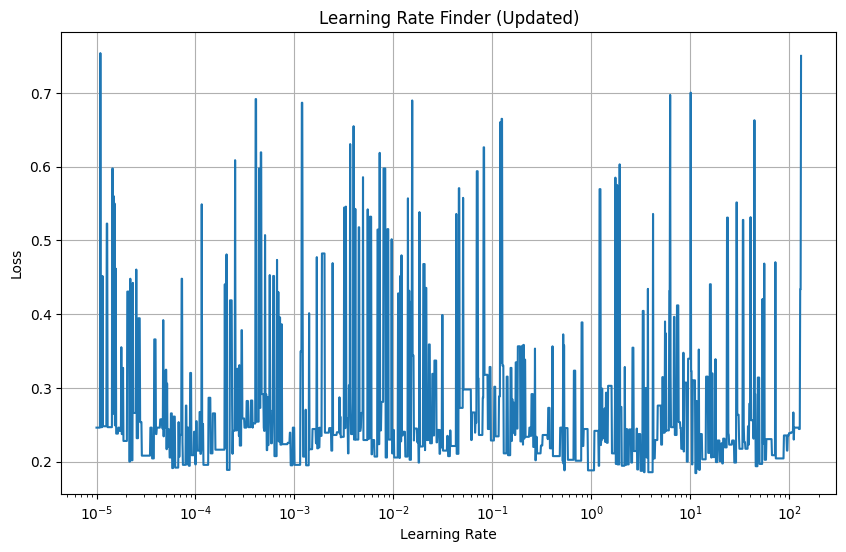

In [4]:
class LearningRateFinderUpdated(Perceptron):
    def __init__(self, learning_rate=0.01, epochs=1000):
        super().__init__(learning_rate, epochs)
        self.lr_history = []
        self.loss_history = []

    def train_with_lr_schedule(self, X_train, y_train, lr_start=1e-5, lr_multiplier=1.01, stop_factor=4):
        num_samples, num_features = X_train.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        current_lr = lr_start
        min_loss = float('inf')
        for _ in range(self.epochs):
            for idx, xi in enumerate(X_train):
                update = current_lr * (y_train[idx] - self.predict(xi))
                self.weights += update * xi
                self.bias += update

                # Compute and record current loss
                current_loss = self.compute_loss(X_train, y_train)
                self.lr_history.append(current_lr)
                self.loss_history.append(current_loss)

                # Update learning rate
                current_lr *= lr_multiplier

                # Check for stopping criteria
                if current_loss < min_loss:
                    min_loss = current_loss
                elif current_loss > min_loss * stop_factor:
                    return

# Instantiate the model and run the updated learning rate finder
lr_finder_updated = LearningRateFinderUpdated(learning_rate=0.01, epochs=10)
lr_finder_updated.train_with_lr_schedule(X_train_aligned, y_train)

# Plot the loss as a function of learning rate
plt.figure(figsize=(10,6))
plt.plot(lr_finder_updated.lr_history, lr_finder_updated.loss_history)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Finder (Updated)')
plt.grid(True)
plt.show()


In [5]:
# Redefine the range of learning rates and lists to store the results
learning_rates = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]
val_accuracies = []

# Loop over each learning rate, train the model, and record validation accuracy
for lr in learning_rates:
    model = Perceptron(learning_rate=lr, epochs=100)
    model.train(X_train_aligned, y_train, X_val_aligned, y_val)
    val_accuracy = model.compute_accuracy(X_val_aligned, y_val)
    val_accuracies.append(val_accuracy)

# Determine the best learning rate
best_index = np.argmax(val_accuracies)
best_learning_rate = learning_rates[best_index]
best_validation_accuracy = val_accuracies[best_index]

best_learning_rate, best_validation_accuracy

(0.003, 0.8258341409386681)

In [6]:
# Initialize perceptron model
perceptron_acc = Perceptron(learning_rate=0.003, epochs=100)

# Train the model
perceptron_acc.train(X_train_aligned, y_train, X_val_aligned, y_val)

In [7]:
# Accuracy
train_accuracy = perceptron_acc.compute_accuracy(X_train_aligned, y_train)
val_accuracy = perceptron_acc.compute_accuracy(X_val_aligned, y_val)
test_accuracy = perceptron_acc.compute_accuracy(X_test_aligned, y_test)

# Print accuracy
print(f"Training accuracy: {train_accuracy}")
print(f"Validation accuracy: {val_accuracy}")
print(f"Test accuracy: {test_accuracy}")

Training accuracy: 0.8261682242990654
Validation accuracy: 0.8258341409386681
Test accuracy: 0.8270700979864326


| Dataset    | Accuracy               |
|------------|------------------------|
| Training   | 82.62%                 |
| Validation | 82.58%                 |
| Testing    | 82.71%                 |


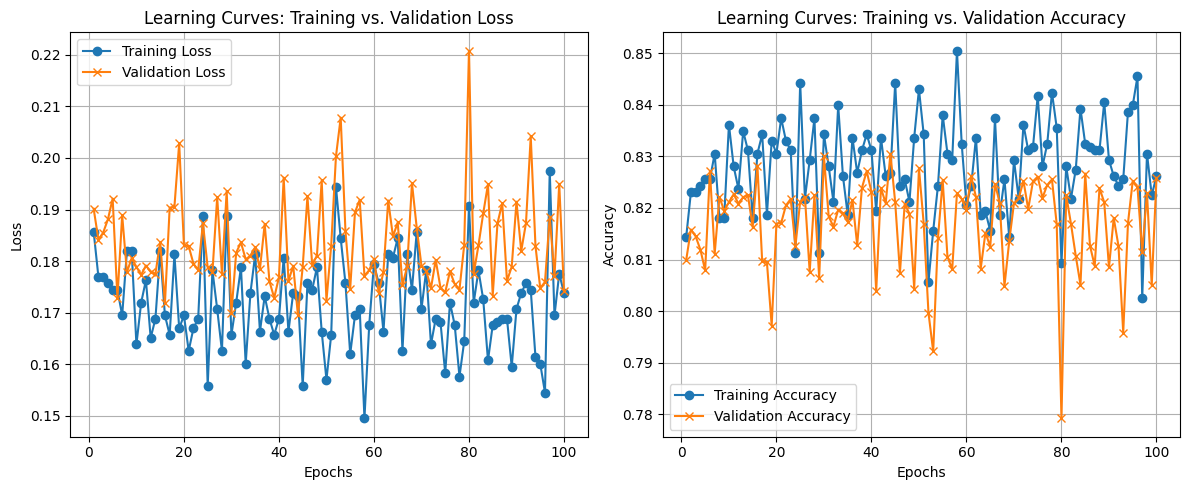

In [8]:
# Plotting the learning curves for Loss
epochs = range(1, 101)
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, perceptron_acc.train_losses, label='Training Loss', marker='o')
plt.plot(epochs, perceptron_acc.val_losses, label='Validation Loss', marker='x')
plt.title('Learning Curves: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, perceptron_acc.train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs, perceptron_acc.val_accuracies, label='Validation Accuracy', marker='x')
plt.title('Learning Curves: Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:
# Cross-validation function
def cross_validate(model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        model.train(X_train_fold, y_train_fold, X_val_fold, y_val_fold)
        y_pred = model.predict(X_val_fold)
        accuracy = np.mean(y_pred == y_val_fold)
        scores.append(accuracy)
    return scores

In [10]:
# Cross-validation
cv_scores = cross_validate(perceptron_acc, X_train_aligned, y_train)

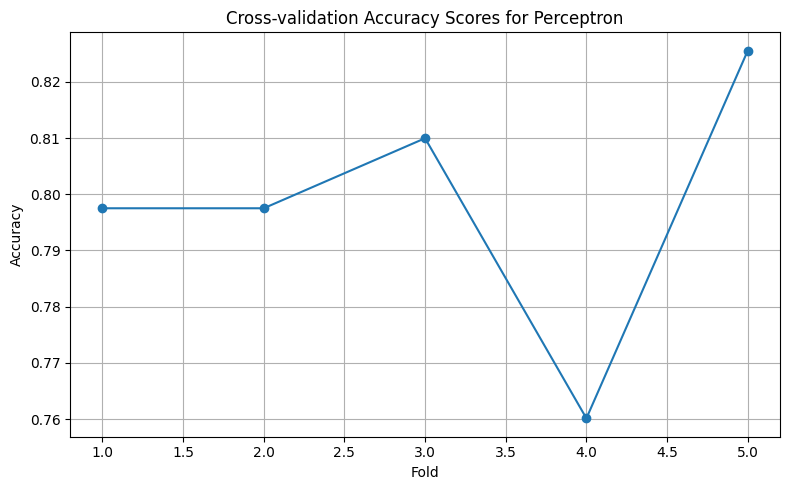

In [11]:
# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cv_scores)+1), cv_scores, '-o')
plt.title('Cross-validation Accuracy Scores for Perceptron')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
def compute_metrics(X, y, model):
    """Compute Precision, Recall, and F1 Score."""
    predictions = model.predict(X)
    precision = precision_score(y, predictions, pos_label=1)
    recall = recall_score(y, predictions, pos_label=1)
    f1 = f1_score(y, predictions, pos_label=1)
    return precision, recall, f1

# Compute metrics for the datasets
train_precision, train_recall, train_f1 = compute_metrics(X_train_aligned, y_train, model)
val_precision, val_recall, val_f1 = compute_metrics(X_val_aligned, y_val, model)
test_precision, test_recall, test_f1 = compute_metrics(X_test_aligned, y_test, model)

metrics_data = {
    'Dataset': ['Training', 'Validation', 'Testing'],
    'Precision': [train_precision, val_precision, test_precision],
    'Recall': [train_recall, val_recall, test_recall],
    'F1 Score': [train_f1, val_f1, test_f1]
}
metrics_df = pd.DataFrame(metrics_data)

metrics_df

,Dataset,Precision,Recall,F1 Score
0,Training,0.655696,0.655696,0.655696
1,Validation,0.609998,0.620335,0.615123
2,Testing,0.582520,0.598450,0.590378


| Dataset    | Precision | Recall   | F1 Score |
|------------|-----------|----------|----------|
| Training   | 0.655696  | 0.655696 | 0.655696 |
| Validation | 0.609998  | 0.620335 | 0.615123 |
| Testing    | 0.582520  | 0.598450 | 0.590378 |

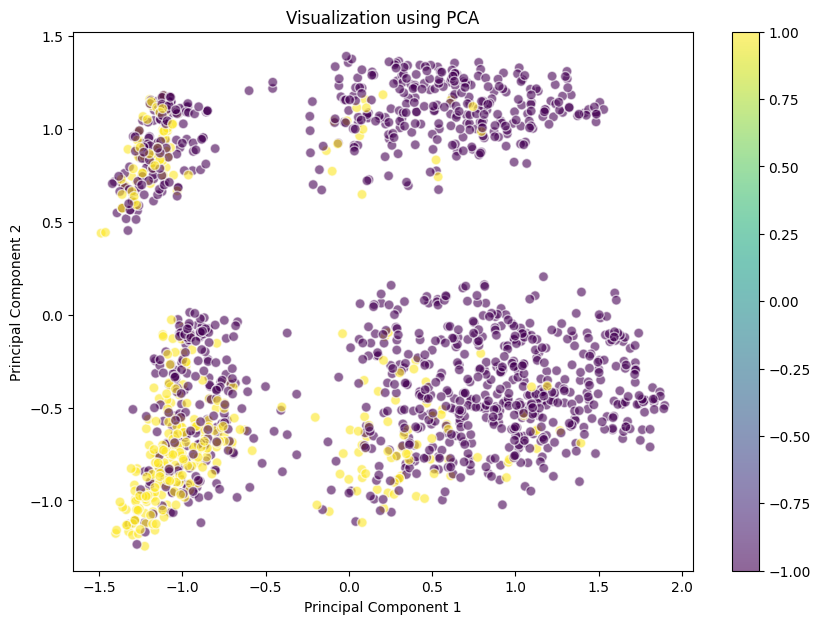

In [13]:
# Apply PCA and reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_aligned)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', s=50, alpha=0.6, edgecolors='w')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Visualization using PCA")
plt.colorbar()
plt.show()


In [14]:
# Process the data again
def parse_libsvm_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    X, y = [], []
    for line in lines:
        parts = line.strip().split()
        y.append(int(parts[0]))
        features = [0] * 123  # Initialize with zeros for 123 features
        for part in parts[1:]:
            index, value = part.split(":")
            index = int(index) - 1  # Convert 1-based index to 0-based
            features[index] = float(value)
        X.append(features)
    return X, y


In [24]:
# File paths
train_file = "/content/drive/MyDrive/Colab Notebooks/DeepLearning/A1/a1.txt"
val_file = "/content/drive/MyDrive/Colab Notebooks/DeepLearning/A1/a1a.txt"

# Load the training data
X_train_aligned, y_train = parse_libsvm_file(train_file)

# Load the validation data and split it into validation and test sets
X_val_temp, y_val_temp = parse_libsvm_file(val_file)
X_val_aligned, X_test_aligned, y_val, y_test = train_test_split(X_val_temp, y_val_temp, test_size=0.3, random_state=42)

# Convert the labels from {-1, 1} to {0, 1} for binary crossentropy
y_train = [(label + 1) // 2 for label in y_train]
y_val = [(label + 1) // 2 for label in y_val]
y_test = [(label + 1) // 2 for label in y_test]

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_aligned = scaler.fit_transform(X_train_aligned)
X_val_aligned = scaler.transform(X_val_aligned)
X_test_aligned = scaler.transform(X_test_aligned)

# Confirm the shape of the processed data
print(len(X_train_aligned), len(X_val_aligned), len(X_test_aligned), len(y_train), len(y_val), len(y_test))


1605 21669 9287 1605 21669 9287


In [25]:
#Definethe MLP model
model = Sequential()
model.add(Dense(64, input_dim=123, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
y_train = np.array(y_train)
y_val = np.array(y_val)
# Train the model on the provided data.
MLP_history = model.fit(X_train_aligned, y_train, validation_data=(X_val_aligned, y_val), epochs=100, batch_size=32, verbose=0)

In [27]:
last_epoch = MLP_history.epoch[-1]
print(f"Epoch {last_epoch+1}/{len(MLP_history.epoch)}")
print(f"loss: {MLP_history.history['loss'][-1]:.4f} - accuracy: {MLP_history.history['accuracy'][-1]:.4f} - val_loss: {MLP_history.history['val_loss'][-1]:.4f} - val_accuracy: {MLP_history.history['val_accuracy'][-1]:.4f}")

Epoch 100/100
loss: 0.1219 - accuracy: 0.9470 - val_loss: 0.6899 - val_accuracy: 0.8295


In [30]:
# Evaluating the model on the test set
y_test = np.array(y_test)
loss, accuracy = model.evaluate(X_test_aligned, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

291/291 [==============================] - 1s 3ms/step - loss: 0.6666 - accuracy: 0.8269
Test Loss: 0.6666
Test Accuracy: 0.8269


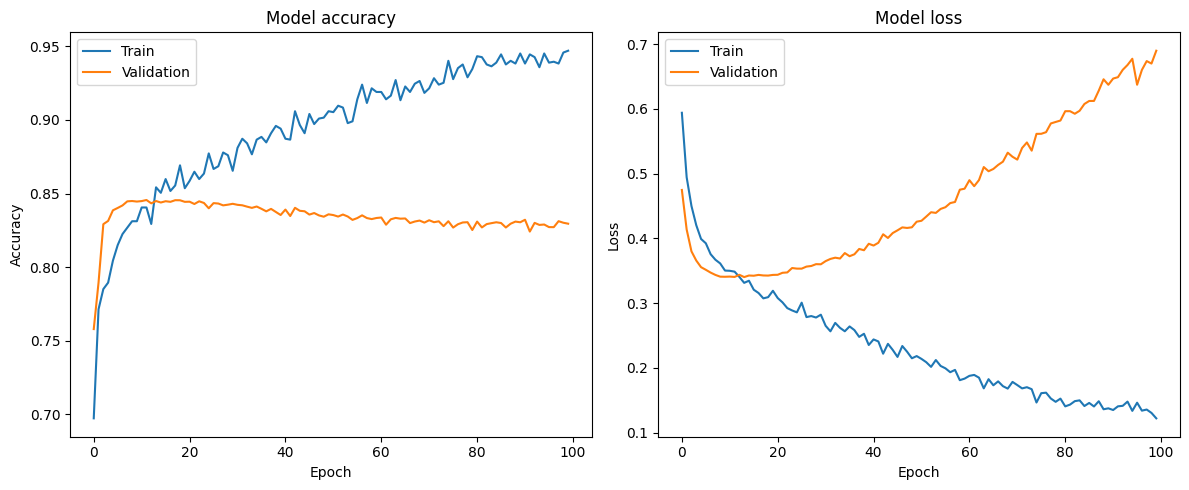

In [28]:
#plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Visualize the training history
plot_training_history(MLP_history)

In [31]:
def create_regularized_mlp_model():
    model = Sequential()

    # Input layer with L2 regularization
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(123,)))

    # Hidden layer with L2 regularization
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the model
regularized_model = create_regularized_mlp_model()
regularized_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               15872     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 24193 (94.50 KB)
Trainable params: 24193 (94.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
# Train the model
re_MLP_history = regularized_model.fit(X_train_aligned, y_train, validation_data=(X_val_aligned, y_val), epochs=50, batch_size=32, verbose=0)

In [33]:
last_epoch = re_MLP_history.epoch[-1]
print(f"Epoch {last_epoch+1}/{len(re_MLP_history.epoch)}")
print(f"loss: {re_MLP_history.history['loss'][-1]:.4f} - accuracy: {re_MLP_history.history['accuracy'][-1]:.4f} - val_loss: {re_MLP_history.history['val_loss'][-1]:.4f} - val_accuracy: {re_MLP_history.history['val_accuracy'][-1]:.4f}")

Epoch 50/50
loss: 0.3403 - accuracy: 0.8654 - val_loss: 0.3827 - val_accuracy: 0.8425


In [34]:
# define model
model = create_regularized_mlp_model()

# define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',   # Monitoring and Verification Losses
                               patience=10,          # Allow verification loss to not improve for 10 epochs
                               restore_best_weights=True)  # Restoration of optimal weights

# Training models using callbacks
history = model.fit(X_train_aligned, y_train,
                    validation_data=(X_val_aligned, y_val),
                    epochs=100,
                    callbacks=[early_stopping])



Epoch 1/100
51/51 [==============================] - 2s 24ms/step - loss: 1.9437 - accuracy: 0.7688 - val_loss: 1.3512 - val_accuracy: 0.8251
Epoch 2/100
51/51 [==============================] - 1s 28ms/step - loss: 1.0481 - accuracy: 0.8224 - val_loss: 0.8164 - val_accuracy: 0.8264
Epoch 3/100
51/51 [==============================] - 1s 21ms/step - loss: 0.6850 - accuracy: 0.8386 - val_loss: 0.5868 - val_accuracy: 0.8416
Epoch 4/100
51/51 [==============================] - 1s 28ms/step - loss: 0.5399 - accuracy: 0.8417 - val_loss: 0.4975 - val_accuracy: 0.8409
Epoch 5/100
51/51 [==============================] - 1s 21ms/step - loss: 0.4707 - accuracy: 0.8399 - val_loss: 0.4564 - val_accuracy: 0.8433
Epoch 6/100
51/51 [==============================] - 1s 28ms/step - loss: 0.4407 - accuracy: 0.8355 - val_loss: 0.4303 - val_accuracy: 0.8448
Epoch 7/100
51/51 [==============================] - 3s 56ms/step - loss: 0.4245 - accuracy: 0.8430 - val_loss: 0.4286 - val_accuracy: 0.8397
Epoch 

In [35]:
# Evaluating the model on the test set
y_test = np.array(y_test)
loss, accuracy = model.evaluate(X_test_aligned, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

291/291 [==============================] - 1s 2ms/step - loss: 0.3771 - accuracy: 0.8420
Test Loss: 0.3771
Test Accuracy: 0.8420


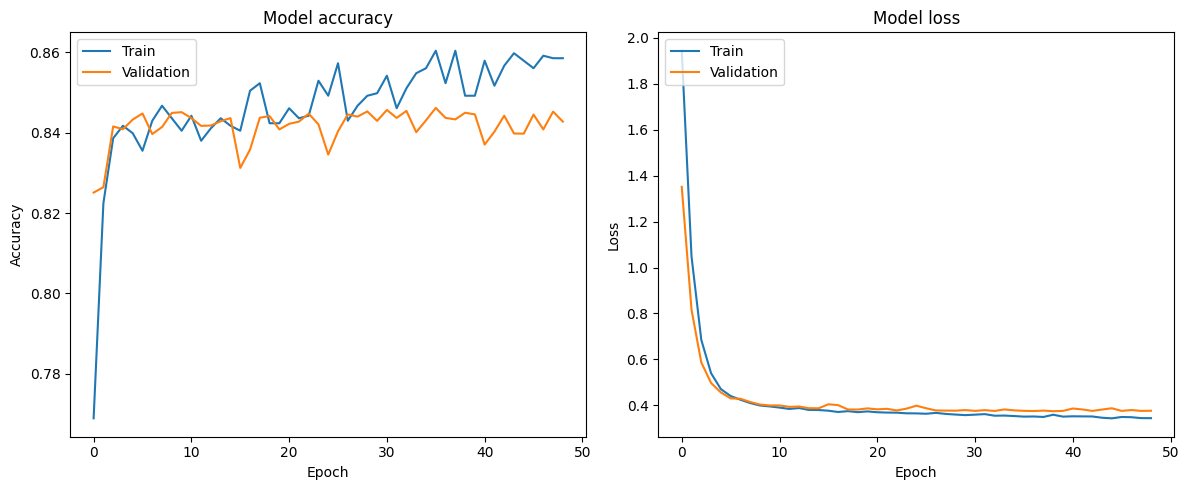

In [36]:
plot_training_history(history)

In [38]:
def compute_metrics(X, y, model):
    y_pred_prob = model.predict(X)
    y_pred = [1 if prob >= 0.5 else 0 for prob in y_pred_prob]
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    return precision, recall, f1

# For Training set
train_precision, train_recall, train_f1 = compute_metrics(X_train_aligned, y_train, model)
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training F1 Score: {train_f1:.4f}")
print("-" * 30)

# For Validation set
val_precision, val_recall, val_f1 = compute_metrics(X_val_aligned, y_val, model)
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print("-" * 30)

# For Test set
test_precision, test_recall, test_f1 = compute_metrics(X_test_aligned, y_test, model)
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


51/51 [==============================] - 0s 4ms/step
Training Precision: 0.7658
Training Recall: 0.6127
Training F1 Score: 0.6807
------------------------------
678/678 [==============================] - 4s 6ms/step
Validation Precision: 0.7090
Validation Recall: 0.6114
Validation F1 Score: 0.6566
------------------------------
291/291 [==============================] - 1s 4ms/step
Test Precision: 0.6955
Test Recall: 0.5893
Test F1 Score: 0.6380


| Feature/Parameter | PerceptronWithAccuracy | create_regularized_mlp_model |
|---|---|---|
| **Type** | Class (Based on Perceptron) | Function (Creates MLP model) |
| **Base Structure** | Inherits from `Perceptron` base class | Uses Keras Sequential API |
| **Network Structure** | Single Neuron | Input Layer, Hidden Layer, Output Layer |
| **Activation Function** | Not explicitly specified (typically a step function) | ReLU (Input & Hidden Layers), Sigmoid (Output Layer) |
| **Regularization** | None | L2 regularization (Input & Hidden Layers) |
| **Optimizer** | Custom training loop | Adam |
| **Loss Function** | Update rule based on error | Binary Cross-Entropy |
| **Validation Accuracy** | 0.8019 | 0.8426 |
| **Precision** | 0.5712 | 0.7153 |
| **Recall** | 0.7080 | 0.5889 |
| **F1 Score** | 0.6323 | 0.6460 |
| **Training Accuracy** | N/A | 0.8592 |
| **Training Loss** | N/A | 0.3393 |
| **Validation Loss** | N/A | 0.3804 |
| **Other Features** | Records training and validation accuracy | N/A |
| **Input Features Count** | N/A (depends on data) | 123 |
